In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import dataset_generation

In [4]:
dataset_generation.SEQ_LEN = 120

In [5]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from theano import sparse
from lasagne.layers import *

from gumbel_sigmoid import GumbelSigmoid

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


### if no module gumbel_sigmoid
!wget https://raw.githubusercontent.com/yandexdataschool/gumbel_lstm/master/gumbel_sigmoid.py

In [44]:
seq_len = theano.shared(dataset_generation.SEQ_LEN)


sequence = sparse.csc_fmatrix('input_seq')
dur_seq = T.fvector('Duration sequence')
d_s_resh = dur_seq.reshape((-1, seq_len, 1))

gumbel_t = theano.shared(np.float32(1.)) #temperature for gumbel-sigmoid

X_gumbel = GumbelSigmoid(gumbel_t)(sequence*1e3)    

seq_gumbel = X_gumbel.reshape((-1, seq_len,128))

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

In [104]:
t = dataset_generation.iterate_minibatches(1, 1)


In [105]:
mat = t.next()
notes = mat[:,:-1].astype("float32")

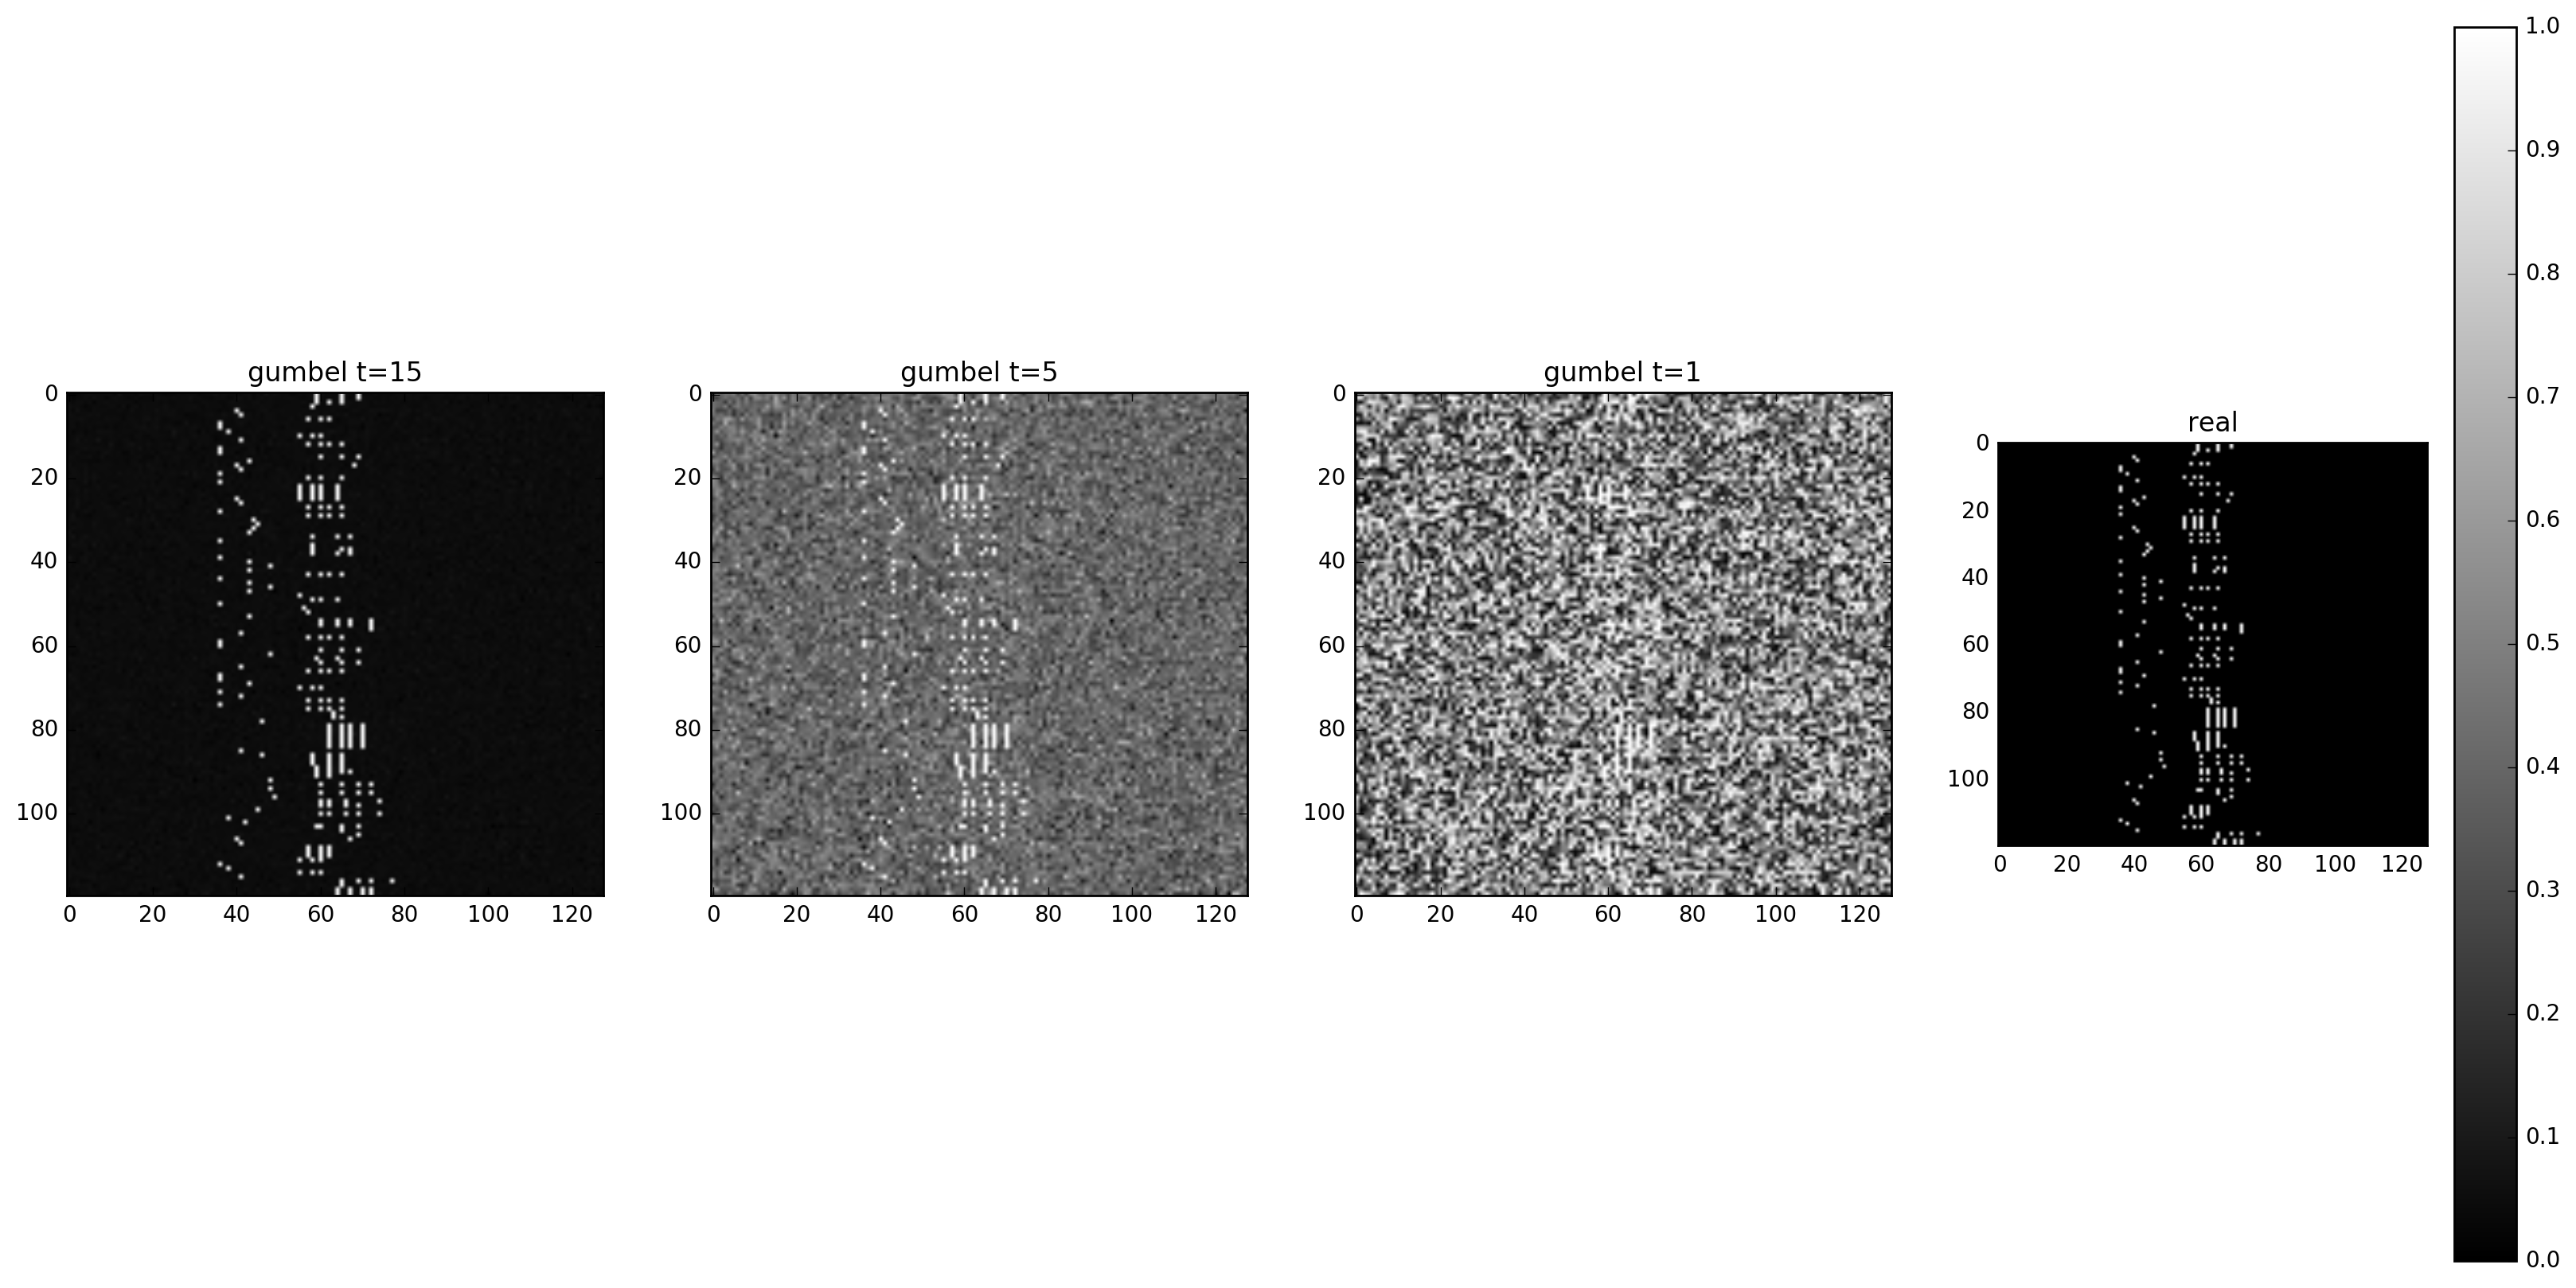

In [106]:
plt.figure(figsize=(20,10))

plt.subplot(1,4,1)
plt.title('gumbel t=15')
gumbel_t.set_value(100)
plt.imshow(seq_gumbel.eval({sequence:notes}).reshape(-1,128),cmap="gray", aspect=1)

plt.subplot(1,4,2)
plt.title('gumbel t=5')
gumbel_t.set_value(5)
plt.imshow(seq_gumbel.eval({sequence:notes}).reshape(-1,128),cmap="gray", aspect=1)

plt.subplot(1,4,3)
plt.title('gumbel t=1')
gumbel_t.set_value(1)
plt.imshow(seq_gumbel.eval({sequence:notes}).reshape(-1,128),cmap="gray", aspect=1)

plt.subplot(1,4,4)
plt.title('real')
gumbel_t.set_value(0.051)
plt.imshow(notes.toarray(), aspect=1 ,cmap="gray")
gumbel_t.set_value(1)

plt.colorbar();

In [11]:
from agentnet import Recurrence
from lasagne.layers import *
from agentnet.memory import *
from agentnet.resolver import ProbabilisticResolver

In [12]:
LSTM_SIZE = 100
EMB_SIZE = 32

In [13]:
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)

## generator

In [58]:
class generator:
    

    NUM_UNITS = 256 #generator RNN size
    CODE_SIZE = 128 # size of uniform noise
    n_steps = seq_len+0#T.iscalar("n_steps for generator")
    
    active_threshold = theano.shared(0.6,"Threshold to sample notes")
    
    n_generated = seq_gumbel.shape[0]
    
    inputZ = srng.uniform((n_generated,CODE_SIZE))
    
    #####NOISE#####
    l_in = InputLayer((None, CODE_SIZE), input_var=inputZ,
                      name='g_input_noise')
    l_rnn_init = DenseLayer(l_in,NUM_UNITS,nonlinearity=T.tanh,
                            name = "gru initial state from noize")
    l_each_tick = DenseLayer(l_in,25,nonlinearity=T.tanh,
                            name = "gru additional input from noize")
    
    
    #####STEP#####
    l_input = InputLayer((None,128))
    l_input_emb = DenseLayer(l_input,32)
    
    l_code = InputLayer((None,25))
    
    l_prev_rnn = InputLayer((None,NUM_UNITS))
    l_new_rnn = GRUCell(l_prev_rnn,[l_input_emb,l_code])
    
    next_dur_ = DenseLayer(l_new_rnn,30,nonlinearity=T.nnet.sigmoid)
    next_dur = DenseLayer(next_dur_,1,nonlinearity=T.nnet.softplus)#softplus since durations are positive
    
    l_pre_out = DenseLayer(l_new_rnn,128,
                         nonlinearity=None)
    
    
    l_probas = NonlinearityLayer(l_pre_out,
                         nonlinearity=T.nnet.sigmoid)
    
    
    l_gumbel = NonlinearityLayer(l_pre_out,
                         nonlinearity=GumbelSigmoid(gumbel_t))
    
    
    feedback_loop = Recurrence(
        state_variables={
            l_new_rnn:l_prev_rnn,
            l_gumbel:l_input
        },
        state_init={l_new_rnn:l_rnn_init},
        input_nonsequences={l_code:l_each_tick},
        tracked_outputs=[l_gumbel,l_probas,next_dur],
        unroll_scan=False,
        n_steps = n_steps
    )
    l_gen = feedback_loop[l_gumbel]
    l_prob = feedback_loop[l_probas]
    l_dur = feedback_loop[next_dur]
    
    assert len(l_gen.output_shape)==3 and l_gen.output_shape[-1] == 128

    weights_gen = get_all_params(l_gen, trainable=True)
    weights_dur = get_all_params(l_dur, trainable=True)
    weights = list(set(weights_gen + weights_dur))
    ###outputs
    output_gumbel,output_probas, output_durs = get_output([l_gen,l_prob,l_dur])
    output_tokens = output_gumbel >= active_threshold
    rng_updates = feedback_loop.get_automatic_updates()
    
    sample = theano.function([n_generated,n_steps],[output_tokens,output_durs],updates=rng_updates)
    sample_probas = theano.function([n_generated,n_steps],[output_gumbel,output_durs],updates=rng_updates)
    
    
    @staticmethod
    def generate(bsize=1,n_steps = dataset_generation.SEQ_LEN):
        #sample indices
        tok, durss = generator.sample(bsize,n_steps)
        return np.hstack([tok.reshape((-1,128)),np.abs(durss.reshape((-1,1)))])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:69: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.


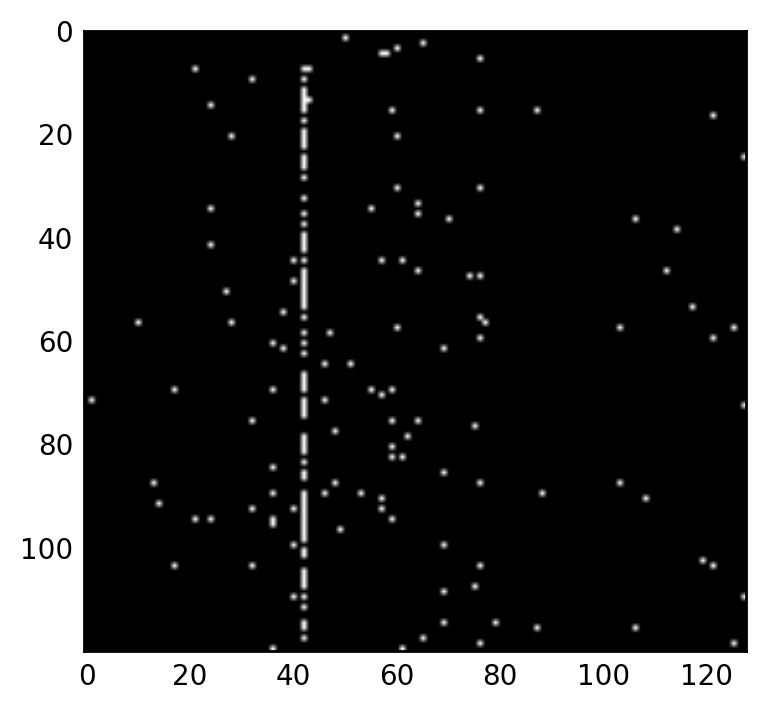

In [119]:
_ress = generator.generate()
plt.imshow(_ress[:,:-1], aspect=1 ,cmap="gray");

## discriminator

In [47]:
from lasagne.nonlinearities import *
from lasagne.init import Normal
from lasagne.layers import *


class discriminator:
    ##########
    #TODO:
    # - make this guy take gumbel sequence as input [None,None,n_tokens]
    # - make this guy output single probability at the end
    # - do not forget to apply MASK to the RNN
    # --- create an input layer for mask.
    # - pairs of inputs:
    # --- fake images: generator.output_gumbel,generator.output_mask
    # --- real images: real_data.output_gumbel,real_data.output_mask
    # - use pure lasagne for now (keep it simple)
    NUM_UNITS=128
    
        
    seq_in = InputLayer((None, None, 128),seq_gumbel,name='d_input')
    durs_in = InputLayer((None, None, 1),d_s_resh, name='d_input_mask')
    
    lstm_in = ConcatLayer([seq_in,durs_in], axis=-1)
    
    lstm_1 = LSTMLayer(lstm_in,NUM_UNITS, 
                            nonlinearity=T.tanh,)

    l_logit = DenseLayer(lstm_1,1,nonlinearity=None,num_leading_axes=2) #P(real|x)
    l_prob = NonlinearityLayer(l_logit,sigmoid)
    
    
    weights = get_all_params(l_prob, trainable=True)
    
    predict = theano.function([sequence,dur_seq],get_output(l_prob)[:,-1])


In [52]:
randomness = theano.shared(0, name="randomness")

In [59]:
class training:
    
    #D(data). Uses default inputs from real_data.*
    p_real_is_real,logit_real = get_output([discriminator.l_prob,discriminator.l_logit])
    
    #D(G(z))    
    p_gen_is_real,logit_gen = get_output([discriminator.l_prob,discriminator.l_logit],
                                           {discriminator.seq_in: generator.output_gumbel,
                                            discriminator.durs_in: generator.output_durs})
    

    
    
    #negative entropy of G
    g_n_entropy = (T.log(generator.output_probas)).sum() / generator.output_probas.shape[0]
    
    ########################
    ###generator training###
    ########################
    
    
    g_loss = - g_n_entropy * randomness - T.log(p_gen_is_real).mean()
    g_updates = lasagne.updates.adagrad(g_loss, generator.weights, 0.005)
    g_train_step = theano.function([generator.n_generated], 
                                   [g_loss, generator.output_probas],
                                   updates=g_updates+generator.rng_updates)

    
    ########################
    #discriminator training#
    ########################
    
    
    d_loss = -T.log(p_real_is_real).mean() - T.log(1-p_gen_is_real).mean()

    #regularize for pre-sigmoid activations
    d_loss += 0.001*(T.mean(logit_real**2) + T.mean(logit_gen**2))

    d_updates = lasagne.updates.adagrad(d_loss, discriminator.weights, 0.005)
    d_train_step = theano.function([sequence, dur_seq],
                                   d_loss, updates=d_updates+generator.rng_updates)
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.


In [101]:
def sample_probas(bsize):
    
    t = dataset_generation.iterate_minibatches(1, bsize)
    mat = t.next()
    notes = mat[:,:-1].astype("float32")
    durations = mat[:,-1].astype("float32").toarray()
    
    D_on_real_data = discriminator.predict(notes,durations.ravel()).ravel()
    
    gen_batch = generator.generate(bsize)
    D_on_gen = discriminator.predict(gen_batch[:,:-1],gen_batch[:,-1]).ravel()
    
    plt.hist(D_on_real_data,label='D(x)', alpha=0.5)
    plt.hist(D_on_gen,label='D(G(z))',alpha=0.5)
    plt.legend(loc='best')
    plt.xlim(0,1)

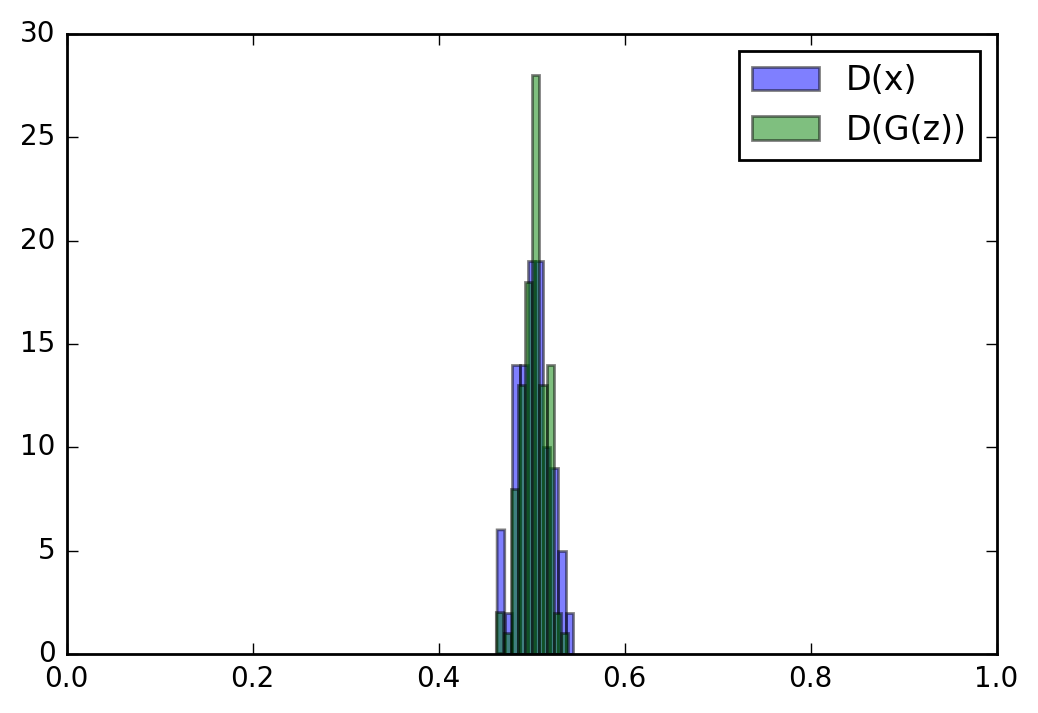

In [102]:
sample_probas(100)

## Training

In [113]:
gumbel_t.set_value(15.0)
randomness.set_value(0)

In [99]:
dataset_generation.SEQ_LEN = 120
seq_len.set_value(dataset_generation.SEQ_LEN)

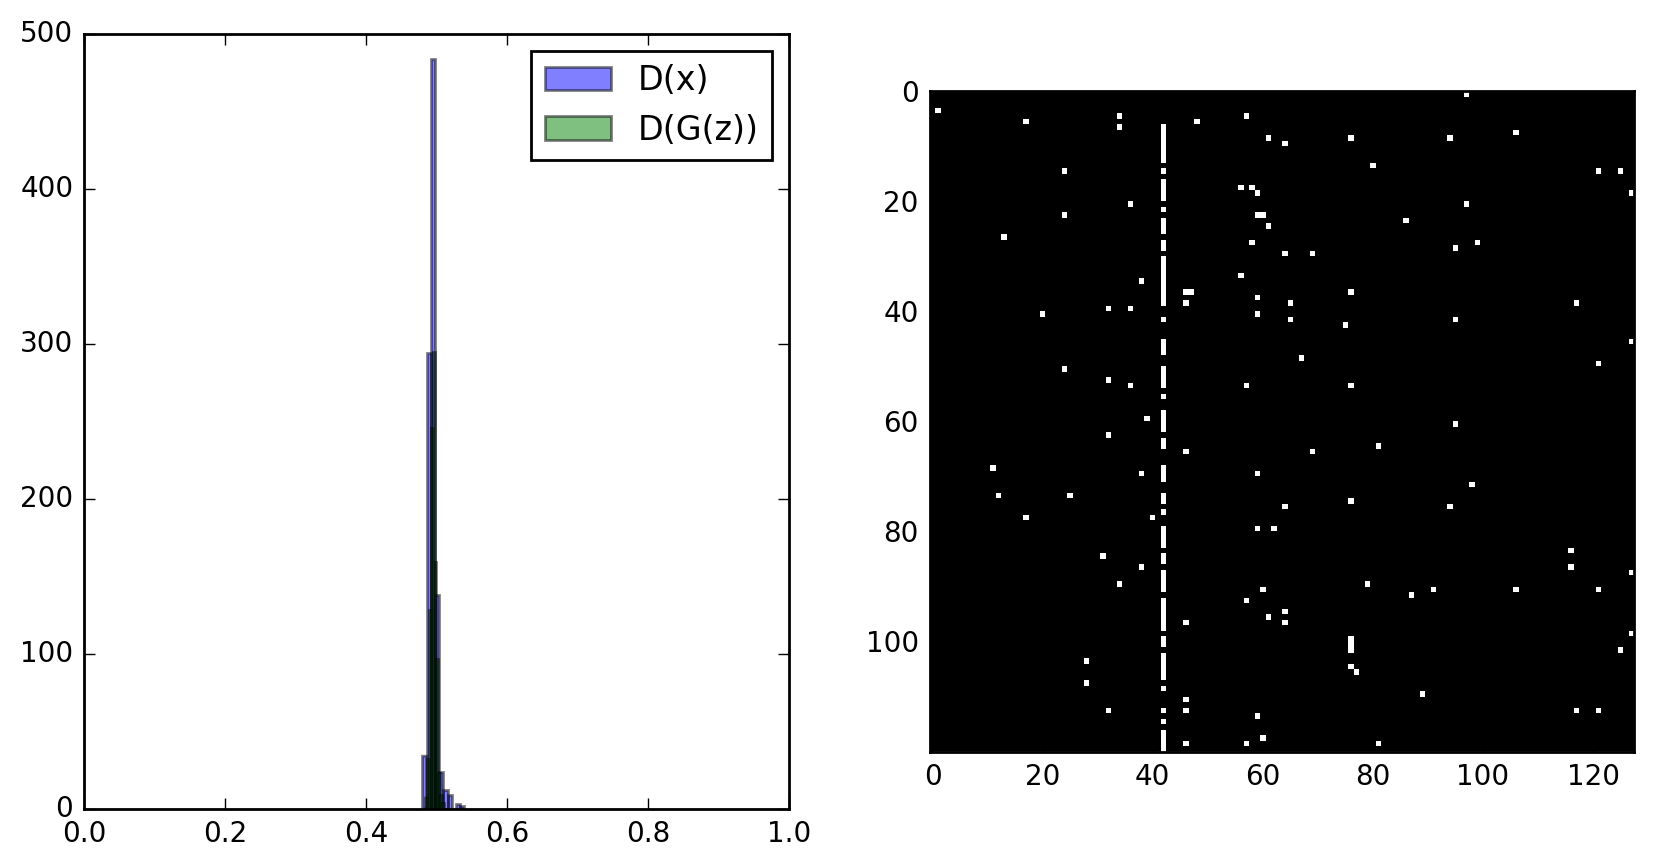

  0%|          | 1/1000 [00:10<2:46:54, 10.02s/it]

D_loss=1.386,G_loss=0.699,gumbel_t=15.000


  0%|          | 3/1000 [00:21<2:08:33,  7.74s/it]

D_loss=1.380,G_loss=0.677,gumbel_t=15.000


In [ ]:
from IPython import display
from tqdm import tqdm
from midi_preproc import save_mat2_mid


probs = None

n_epochs = 1000
batch_size = 128
epoch = 0
for batch in tqdm(dataset_generation.iterate_minibatches(n_epochs, batch_size),total=n_epochs):
    notes = batch[:,:-1].astype("float32")
    durations = batch[:,-1].astype("float32").toarray()
    for i in range(3):
        d_loss = training.d_train_step(notes,durations.ravel())
    for i in range(3):
        g_loss, probs = training.g_train_step(batch_size)
        
        
    gumbel_t.set_value((gumbel_t.get_value()*(1-0.0000)).astype("float32"))

    if epoch %10==0:
        plt.figure(figsize=(10,5))
        display.clear_output(wait=True)
        plt.subplot(1,2,1)
        sample_probas(1000)
        plt.subplot(1,2,2)
        _ress = generator.generate()
        plt.imshow(_ress[:,:-1], aspect=1 ,interpolation="none",cmap="gray")
        plt.show()
        save_mat2_mid(_ress)
    if epoch%2==0:
        print 'D_loss=%.3f,G_loss=%.3f,gumbel_t=%.3f'%(d_loss,g_loss,gumbel_t.get_value())
    epoch+=1

In [116]:
import pickle as pkl

In [117]:
with open('params_GAN.pkl','wb') as f:
    for w in generator.weights:
        pkl.dump(w.get_value(), f)
    for w in discriminator.weights:
        pkl.dump(w.get_value(), f)

In [118]:
with open('params_GAN.pkl','rb') as f:
    for w in generator.weights:
        w.set_value(pkl.load( f))
    for w in discriminator.weights:
        w.set_value(pkl.load( f))